In [121]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms.functional as F
import torchvision.transforms as T
from torchvision.io import ImageReadMode, read_image
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import glob

In [122]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split

In [123]:
dataset_path = "../../pics/2750/"
transform = ToTensor()
dataset = ImageFolder(dataset_path, transform=transform)

In [124]:
dataset.class_to_idx

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [125]:
#selected_classes = ['Forest', 'Industrial']
#selected_class_to_idx = {class_name: class_idx for class_name, class_idx in dataset.class_to_idx.items() if class_name in selected_classes}
# build subset
idx = [i for i in range(len(dataset)) if (dataset.imgs[i][1] == dataset.class_to_idx['Industrial'] or dataset.imgs[i][1] == dataset.class_to_idx['Forest']) ]
subset = torch.utils.data.Subset(dataset, idx)
 
for sample_idx in range(len(subset)):
    sample = subset[sample_idx]

    # Access the image and label from the sample
    image, label = sample

    # Print or examine the sample
    if sample_idx % 1000 == 0:
        print("Sample:", sample_idx, "Image shape:", image.shape, "Label:", label)


Sample: 0 Image shape: torch.Size([3, 64, 64]) Label: 1
Sample: 1000 Image shape: torch.Size([3, 64, 64]) Label: 1
Sample: 2000 Image shape: torch.Size([3, 64, 64]) Label: 1
Sample: 3000 Image shape: torch.Size([3, 64, 64]) Label: 4
Sample: 4000 Image shape: torch.Size([3, 64, 64]) Label: 4
Sample: 5000 Image shape: torch.Size([3, 64, 64]) Label: 4


Image:


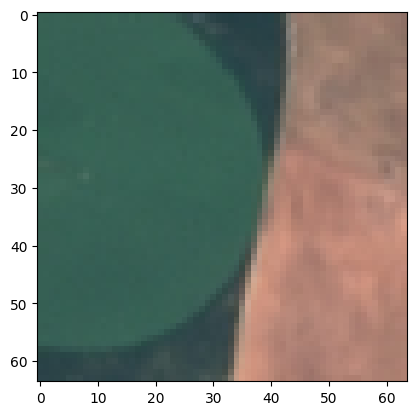

Label: 0
----------------------------------------
Image:


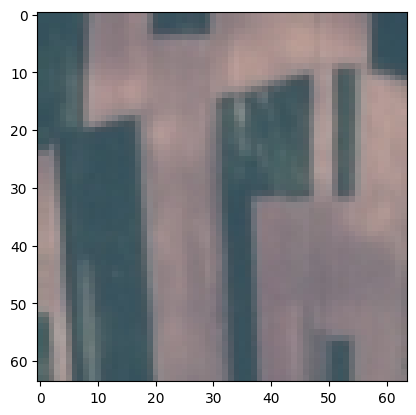

Label: 0
----------------------------------------


In [126]:
# Iterate over the forest_industrial_dataset
for sample in forest_industrial_dataset:
    image = sample[0]  # Get the image
    label = sample[1]  # Get the label
    
    # Display the image and label information
    print("Image:")
    plt.imshow(image.permute(1, 2, 0))  # Permute dimensions to (height, width, channels)
    plt.show()
    
    print("Label:", label)
    print("----------------------------------------")


In [127]:
# Define the train-validation split ratio (e.g., 0.8 for 80% training, 0.2 for 20% validation)
train_ratio = 0.8
train_size = int(train_ratio * len(subset))
val_size = len(subset) - train_size

# Verify that the sum of train_size and val_size is equal to the length of the dataset
if train_size + val_size != len(subset):
    raise ValueError("Sum of train_size and val_size does not equal the length of the dataset!")

In [128]:
# Split the dataset into train and validation sets
train_dataset, val_dataset = torch.utils.data.random_split(subset, [train_size, val_size])

# Create dataloaders for train and validation sets
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)


In [129]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        self.drop1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(120, 84)
        self.drop2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(84, 2)  # Change the output size to 2
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [130]:
label_values = [label for _, label in subset]
unique_labels = set(label_values)
print("Unique Labels:", unique_labels)

Unique Labels: {1, 4}


In [131]:
import torch.optim as optim

In [132]:
# Initialize the CNN model
model = CNN()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Set the number of epochs
num_epochs = 20

In [133]:
train_iter = iter(train_dataloader)
images, labels = next(train_iter)

In [134]:
# Map class labels to the range [0, num_classes-1]
mapped_labels = [0 if label == 1 else 1 for label in label_values]

# Verify the updated unique labels
unique_mapped_labels = set(mapped_labels)
print("Unique Mapped Labels:", unique_mapped_labels)

# ...

# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        # Map the labels to the range [0, num_classes-1]
        mapped_labels = [0 if label == 1 else 1 for label in labels]
        mapped_labels = torch.tensor(mapped_labels)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, mapped_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_dataloader)

    print(f'Epochs: {epoch + 1:5d} | Loss: {epoch_loss:.4f}')


Unique Mapped Labels: {0, 1}
Epochs:     1 | Loss: 0.6945
Epochs:     2 | Loss: 0.6767
Epochs:     3 | Loss: 0.6124
Epochs:     4 | Loss: 0.3571
Epochs:     5 | Loss: 0.1264
Epochs:     6 | Loss: 0.0217
Epochs:     7 | Loss: 0.0084
Epochs:     8 | Loss: 0.0051
Epochs:     9 | Loss: 0.0038
Epochs:    10 | Loss: 0.0029
Epochs:    11 | Loss: 0.0026
Epochs:    12 | Loss: 0.0021
Epochs:    13 | Loss: 0.0019
Epochs:    14 | Loss: 0.0016
Epochs:    15 | Loss: 0.0015
Epochs:    16 | Loss: 0.0014
Epochs:    17 | Loss: 0.0013
Epochs:    18 | Loss: 0.0013
Epochs:    19 | Loss: 0.0011
Epochs:    20 | Loss: 0.0011


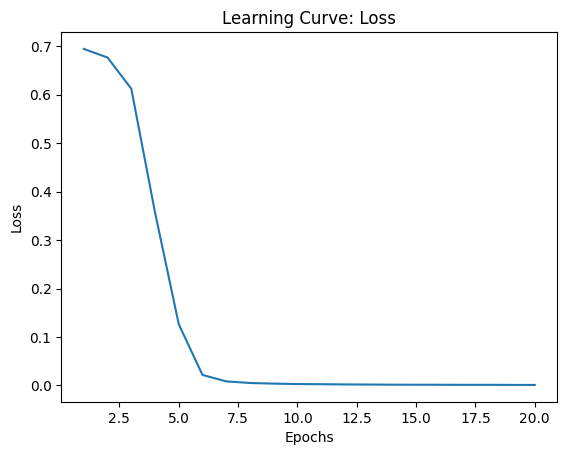

In [135]:
epochs = list(range(1, 21))
loss_values = [0.6945, 0.6767, 0.6124, 0.3571, 0.1264, 0.0217, 0.0084, 0.0051, 0.0038, 0.0029,
               0.0026, 0.0021, 0.0019, 0.0016, 0.0015, 0.0014, 0.0013, 0.0013, 0.0011, 0.0011]

# Plot learning curve (loss)
plt.plot(epochs, loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve: Loss')
plt.show()

In [140]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_dataloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total

if (epoch + 1) % 10 == 0:
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch [20/20], Loss: 0.0011, Accuracy: 0.0000
